### Import Libraries

In [1]:
import numpy as np
import healpy as hp
import scipy.integrate as scinteg
import scipy.interpolate as scinterp
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

In [79]:
import importlib
from potential import potential as fdm_pot
from construct import construct as fdm_con
from halo import halo as fdm_hal
importlib.reload(fdm_pot)
importlib.reload(fdm_con)
importlib.reload(fdm_hal)

<module 'halo.halo' from '/Users/tyavetz/Documents/Academics/02_FDM/01_SchwarzMethod/Code/fdmtools/fdmtools/fdmtools/halo/halo.py'>

### Set Constants and FDM particle mass

In [3]:
G = 4.30091727e-6
hbar = 6.582119569509067e-16    # Reduced Planck constant in eV * s
c_constant = 2.99792458e5       # Speed of light in km/s

# Conversions:
km_to_kpc = 3.240779289444365e-17       # Conversion from km to kpc
km_s_to_kpc_gyr = 1.022712165045695     # Conversion from km/s to kpc/Gyr

# Quantum Mechanics
m_a = 8.1e-23                                          # FDM particle mass in eV / c^2
h_over_m = hbar / (m_a / c_constant**2) * km_to_kpc     # Scaled unit (h_bar / m_a) in astrophysical units: (kpc * km / s)

### Set up halo density, potential, and distribution function, and plot some things

46.37291483207672


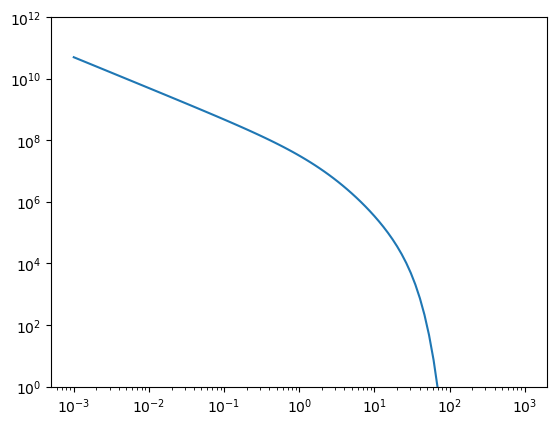

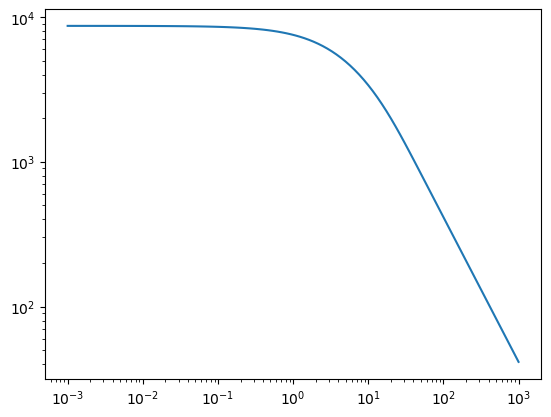

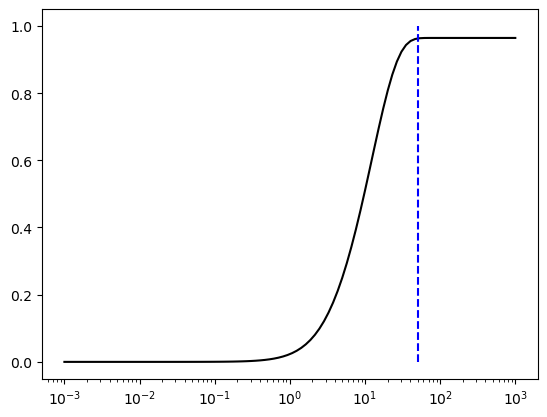

In [85]:
R_fit = 50.
r_setup = np.logspace(-3, 3, 100)
M_target = 1e10
a_scale = 5.

a1 = 4.
b1 = 25.
rho_target = lambda r: M_target / (4. * np.pi * a1**3.) * (r / a1)**(-1.) * (1. + r / a1)**(-2.) * np.exp(-r**2. / b1**2.)

phi1, rho1, M1_tot = fdm_pot.initialize_potential(rho_target)

fE1 = fdm_pot.DF_invert(phi1, rho1)

print(np.max(v_circ(r_setup)))
plt.loglog(r_setup, rho1(r_setup))
plt.ylim(1., 1e12)
plt.show()
plt.loglog(r_setup, -phi1(r_setup))
plt.show()
# plt.loglog(r_setup, v_circ(r_setup))
# plt.show()

dM = lambda r: 4. * np.pi * rho1(r) * r**2

M_total = np.zeros(100)
for i in range(100):
    M_total[i], err = scinteg.quad(dM, 0., r_setup[i])
    
plt.semilogx(r_setup, M_total / M_target, 'k-')
plt.plot([R_fit, R_fit], [0., 1.], 'b--')
plt.show()

### Set relevant scales and initialize radial array for creating the Schwarzschild realization

In [66]:
res = 0.4

R_min = res
steps = int(R_fit // res + 1)
print(steps)
r_array = np.linspace(R_min, R_fit, num=steps)

125
0.4
0.4


### Compute the eigenvalues and eigenvectors and plot the first few eigenmodes

Sampling grid for eigenvalue problem includes 20000 bins, out to r_max * 1.2 = 60.0 kpc
(returning only eigenmodes contained within r_max = 50.0 kpc)
n_max = 30; l_max = 54; distinct nl eigenmodes = 784; total eigenmodes = 27238


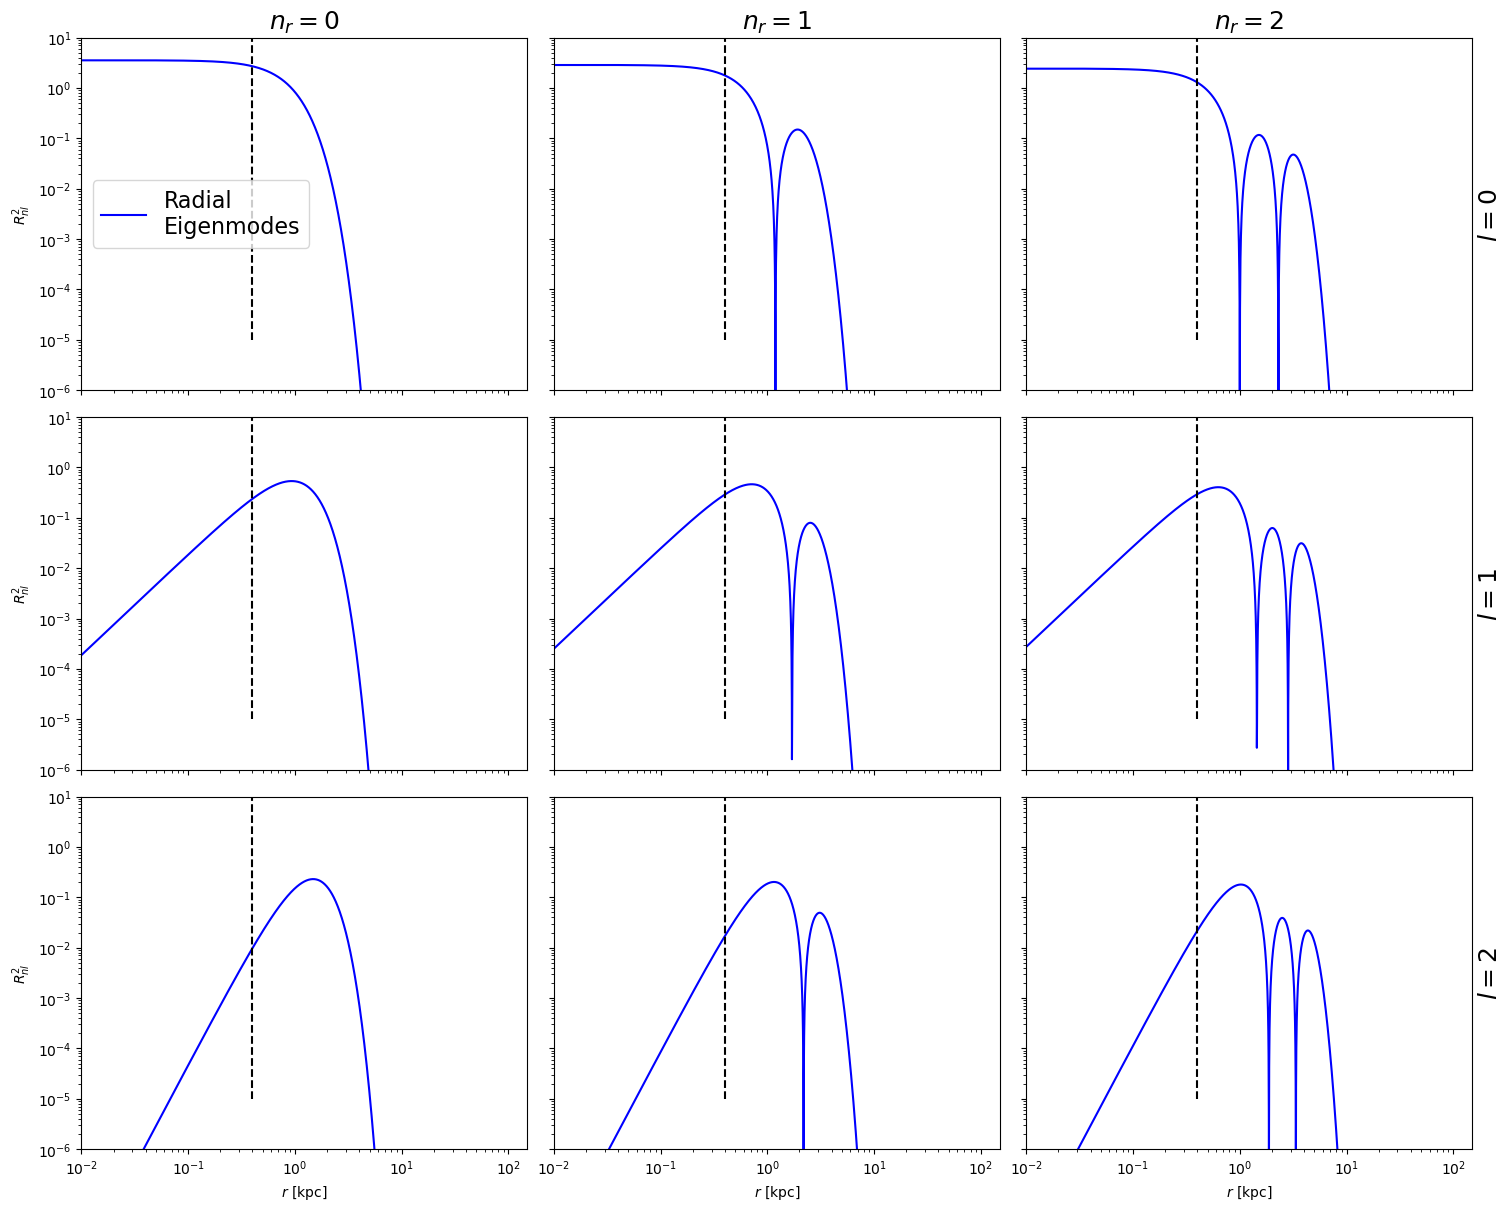

In [67]:
nsteps = 20000
E_nl1, R_nl1 = fdm_con.compute_radial_solutions(m_a, phi1, rho1, R_fit, nsteps, verbose=False)

r_plot = np.linspace(0., R_fit, 10000)

fig, f_axes = plt.subplots(ncols=3, nrows=3, figsize=(15, 12), constrained_layout=True, sharex=True, sharey=True)

loffset = 0
noffset = 0

for l in range(3):
    for n in range(3):
        if R_nl1[n+noffset, l+loffset] is not None:
            f_axes[l, n].loglog(r_plot, np.abs(R_nl1[n+noffset, l+loffset](r_plot))**2., 'b-', label='Radial\nEigenmodes')
        f_axes[l, n].set_xlim(0.01, 150.)
        f_axes[l, n].set_ylim(0.000001, 10.)
        f_axes[l, n].plot([res, res], [0.00001, 10.], 'k--')
        if l==0:
            f_axes[l, n].set_title('$n_r = $' + str(n), fontsize=18)
        if l==2:
            f_axes[l, n].set_xlabel('$r$ [kpc]')
        if n==0:
            f_axes[l, n].set_ylabel('$R_{nl}^2$')
        if n==2:
            f_axes[l, n].set_ylabel('$l = $' + str(l), fontsize=18)
            f_axes[l, n].yaxis.set_label_position("right")
            
f_axes[0, 0].legend(fontsize=16)
plt.show()

### Solve for and plot the amplitudes of each eigenmode

Generally we should do this using the Schwarzschild method, but for this demonstration I just use the Widrow-Kaiser formulation based on the classical distribution function

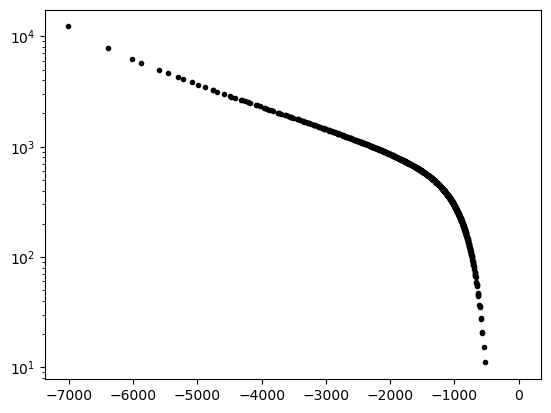

In [68]:
a_nlm1 = fdm_con.amp_from_fE(m_a, E_nl1, fE1, Type='Isotropic')
plt.semilogy(E_nl1, a_nlm1,'k.')
plt.show()

### Compare input and output halo mass and density out to $R_\mathrm{fit}$

9.983381834125858
9.976261869270628
0.9837393306125153


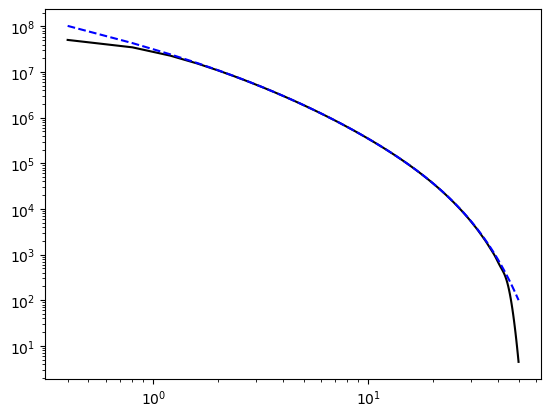

In [69]:
dM = lambda r: 4. * np.pi * rho1(r) * r**2

M_test = scinteg.quad(dM, 0., R_fit)
print(np.log10(M_test[0]))

M_test1 = 0.
dens = np.zeros_like(r_array)

shape = np.shape(a_nlm1)
for n in range(shape[0]):
    for l in range(shape[1]):
        if E_nl1[n, l] != 0.:
            dens += a_nlm1[n, l]**2 * R_nl1[n, l](r_array)**2 * (2 * l + 1) / np.pi / 4.
            M_test1 += a_nlm1[n, l]**2 * (2 * l + 1)
        
print(np.log10(M_test1))
print(M_test1 / M_test[0])

plt.loglog(r_array, dens, 'k-')
plt.loglog(r_array, rho1(r_array), 'b--')
plt.show()

### Compute random phases for each eigenmode

In [70]:
nmax, lmax = np.shape(a_nlm1)
phase_nlm1 = fdm_con.random_phase(nmax, lmax)

### Evolve phases for 10 timesteps of 10 Myr each

In [71]:
t_array = np.linspace(0, 0.1, 11)
phase_nlm1_array = fdm_con.evolve_phase(m_a, phase_nlm1, E_nl1, t_array)

### Solve for density grids and $\rho_{\ell m}$ on a radial grid using Healpix

In [72]:
rho_lms, grid = fdm_hal.halo_density(r_array, E_nl1, R_nl1, a_nlm1, phase_nlm1, verbose=True)

Progress:
Shell 0 out of 125
Shell 20 out of 125
Shell 40 out of 125
Shell 60 out of 125
Shell 80 out of 125
Shell 100 out of 125
Shell 120 out of 125


### Compare input density profile, time averaged density profile, and density profile snapshot averaged over the sphere

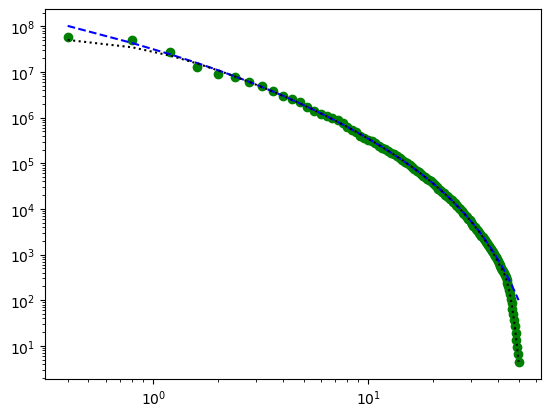

In [73]:
rho_avg = np.zeros(steps)
for i in range(steps):
    rho_avg[i] = np.mean(grid[i])

plt.loglog(r_array, rho_avg, 'go')
plt.loglog(r_array, rho1(r_array), 'b--')
plt.loglog(r_array, dens, 'k:')

plt.show()

In [74]:
print(np.shape(rho_lms))

(125, 73920)


### Calculate $\Phi_{\ell m}$ from $\rho_{\ell m}$ using variation of parameters

In [75]:
Phi_lms = fdm_hal.halo_potential(r_array, rho_lms, verbose=True)

383
Progress:
Shell 0 out of 125
Shell 20 out of 125
Shell 40 out of 125
Shell 60 out of 125
Shell 80 out of 125
Shell 100 out of 125
Shell 120 out of 125


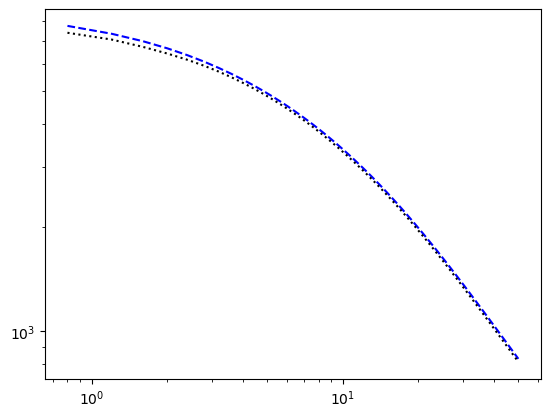

In [76]:
phi_out_compare = np.zeros(steps)

for i in range(steps):
    Phi_test_map = hp.alm2map(Phi_lms[i], nside=64)
    phi_out_compare[i] = np.mean(Phi_test_map)

plt.loglog(r_array[1:], -phi1(r_array[1:]), 'b--')
plt.loglog(r_array[1:], -phi_out_compare[1:], 'k:')
plt.show()

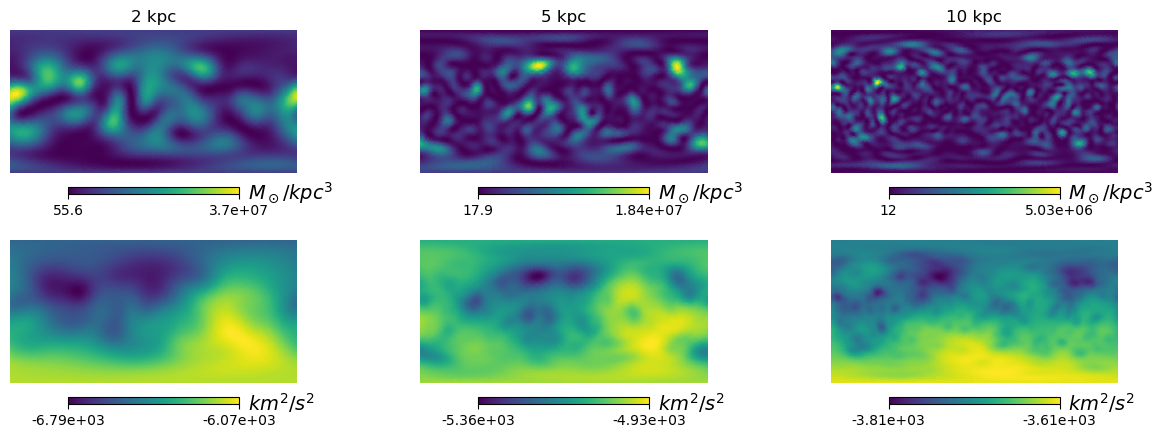

In [77]:
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

plt.axes(axs[0,0])
hp.cartview(hp.alm2map(rho_lms[4], nside=64), coord='G', hold=True, title='2 kpc', notext=True, unit=r'$M_\odot / kpc^3$')
plt.axes(axs[0,1])
hp.cartview(hp.alm2map(rho_lms[10], nside=64), coord='G', hold=True, title='5 kpc', notext=True, unit=r'$M_\odot / kpc^3$')
plt.axes(axs[0,2])
hp.cartview(hp.alm2map(rho_lms[20], nside=64), coord='G', hold=True, title='10 kpc', notext=True, unit=r'$M_\odot / kpc^3$')

plt.axes(axs[1,0])
hp.cartview(hp.alm2map(Phi_lms[4], nside=64), coord='G', hold=True, title='', notext=True, unit=r'$km^2 / s^2$')
plt.axes(axs[1,1])
hp.cartview(hp.alm2map(Phi_lms[10], nside=64), coord='G', hold=True, title='', notext=True, unit=r'$km^2 / s^2$')
plt.axes(axs[1,2])
hp.cartview(hp.alm2map(Phi_lms[20], nside=64), coord='G', hold=True, title='', notext=True, unit=r'$km^2 / s^2$')

plt.show()

In [78]:
print(np.shape(phase_nlm1_array))
print(r_array[1] - r_array[0])

(30, 54, 109, 11)
0.4


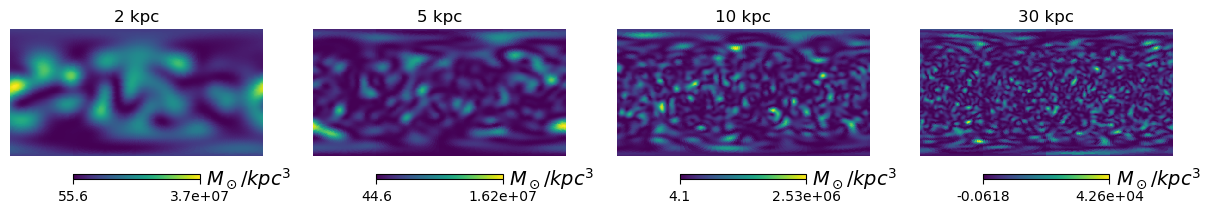

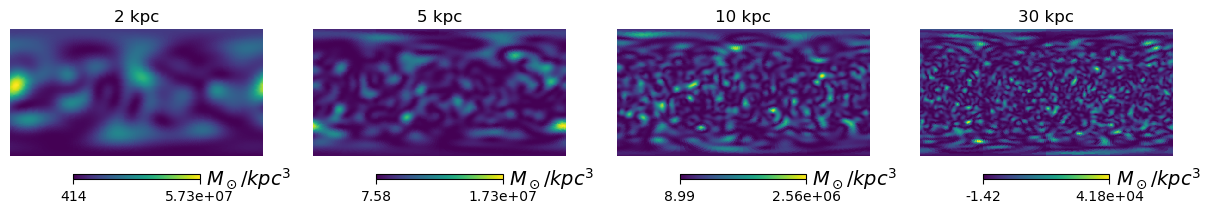

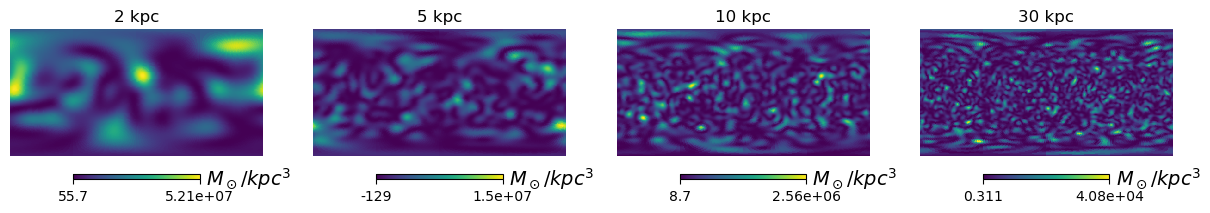

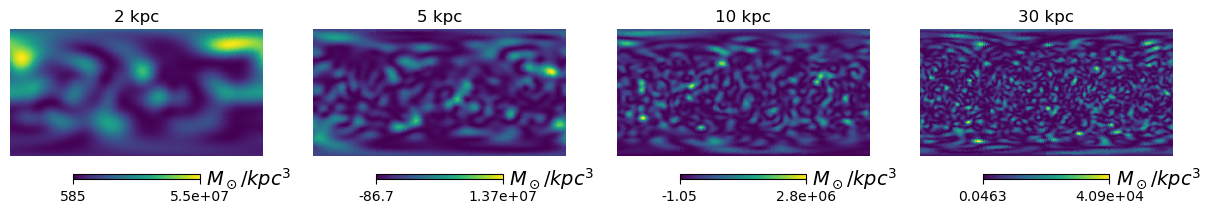

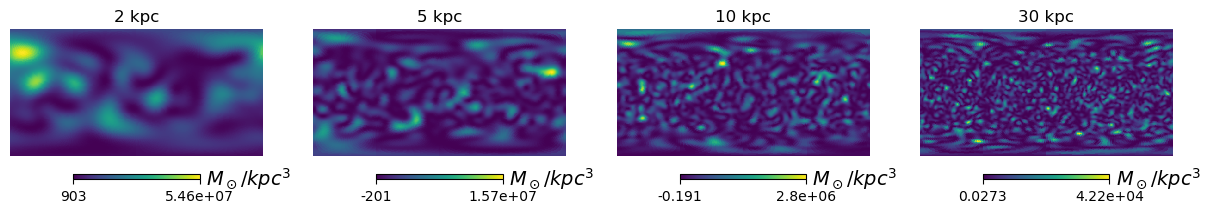

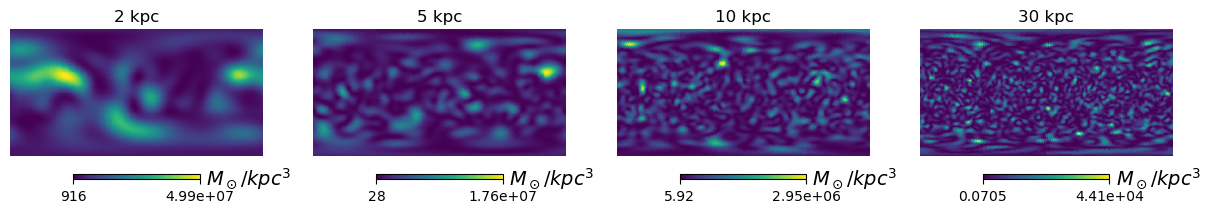

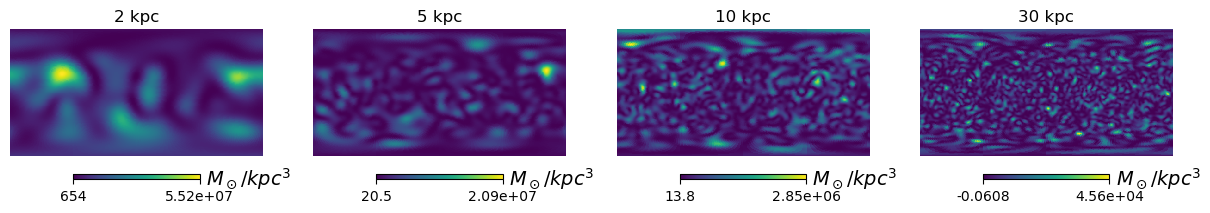

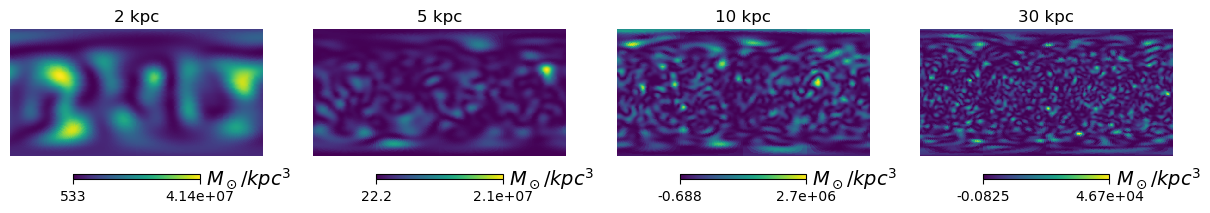

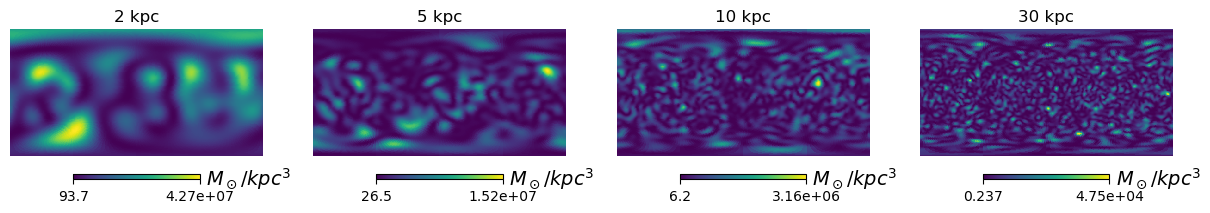

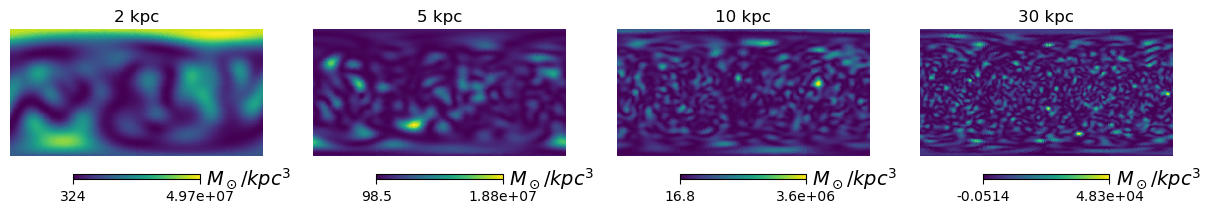

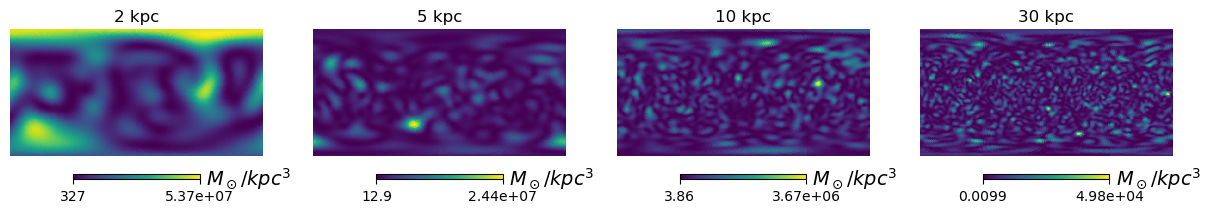

In [82]:
r_evolve = np.array([2., 5., 10., 30.])

for i in range(len(t_array)):
    rho_lms, grid = fdm_hal.halo_density(r_evolve, E_nl1, R_nl1, a_nlm1, phase_nlm1_array[:,:,:,i], res=res, verbose=False)

    fig, axs = plt.subplots(1, 4, figsize=(15, 3))

    plt.axes(axs[0])
    hp.cartview(hp.alm2map(rho_lms[0], nside=64), coord='G', hold=True, title='2 kpc', notext=True, unit=r'$M_\odot / kpc^3$')
    plt.axes(axs[1])
    hp.cartview(hp.alm2map(rho_lms[1], nside=64), coord='G', hold=True, title='5 kpc', notext=True, unit=r'$M_\odot / kpc^3$')
    plt.axes(axs[2])
    hp.cartview(hp.alm2map(rho_lms[2], nside=64), coord='G', hold=True, title='10 kpc', notext=True, unit=r'$M_\odot / kpc^3$')
    plt.axes(axs[3])
    hp.cartview(hp.alm2map(rho_lms[3], nside=64), coord='G', hold=True, title='30 kpc', notext=True, unit=r'$M_\odot / kpc^3$')
    
    plt.show()